# REAPER Gain Volume faders

I think the formulas I've found are correct:
```js
const LN10_OVER_TWENTY = Math.log(10) / 20
// from msg board: https://forum.cockos.com/showthread.php?p=2200278#post2200278
// const LN10_OVER_TWENTY = 0.11512925464970228420089957273422
function dB2gain(dB) {
    return Math.exp(dB * LN10_OVER_TWENTY)
}
function gain2dB(gain) {
    return gain < 0.0000000298023223876953125 ? -150 : Math.max(-150, Math.log(gain) * 8.6858896380650365530225783783321)
}
```

However, the problem becomes what gain (or dB) to interpolate the fader positions from all the way down to up, or `[0.0, 1.0]` by constant step, or 128 MIDI values.

I used the ReaScript API to get the reported `D_VOL` (I believe this is decibel gain) after all the MIDI automation values of `[0, 127]`, defining below:

In [1]:
import IPython.display as ipd, numpy as np, matplotlib.pyplot as plt, scipy as sy, json

with open('reaperMidiFaderValues.json') as f:  
    fader = json.load(f)
ipd.display(fader[0:5], '...', fader[-5:])

[3.1622776601684e-08,
 9.7176007832866e-07,
 7.7741071932127e-06,
 2.6237855145973e-05,
 6.2194557807039e-05]

'...'

[3.4510913705484,
 3.5773381215922,
 3.7076728528676,
 3.8422112595862,
 3.981071705535]

So, putting that into numpy array and plotting:

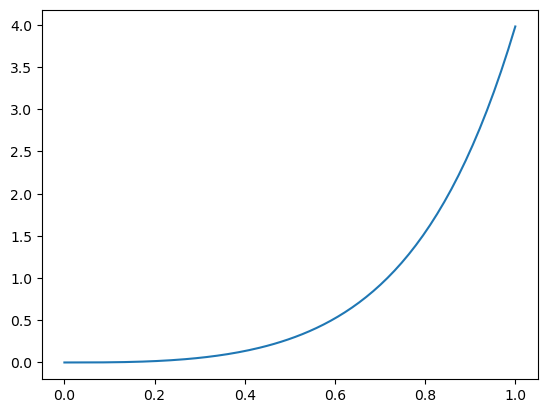

In [2]:
y = np.array(fader)
x = np.array([i/127 for i in range(128)])
plt.plot(x, y, '-')
plt.show()

I think this is exponential looking? And that should align with volume / power? So I try curve fitting.

In [3]:
def func(x, a, b, c):
    return a * np.exp(b * x) + c

x = np.array([i/127 for i in range(128)])
params, _ = sy.optimize.curve_fit(func, x, y)
params

array([ 0.03656071,  4.72474091, -0.08241487])

Let's see them together:

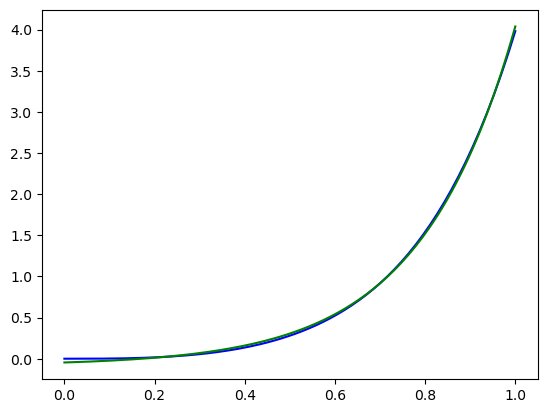

In [4]:
fitted_curve = params[0] * np.exp(params[1] * x) + params[2]
plt.plot(x, y, '-b', x, fitted_curve, '-g')
plt.show()

Holy shit, looks pretty good! Will try this instead of look up table.

Update: Darn, not so fast. Tried, and that tiny difference over the first 20 is pretty bad. Those are negative values, for about x = 20 and below. I saw a bounds parameter, but that's only for the guessed params, not constraining y for instance. Let's zero in on the most problematic looking, around x less than 85.

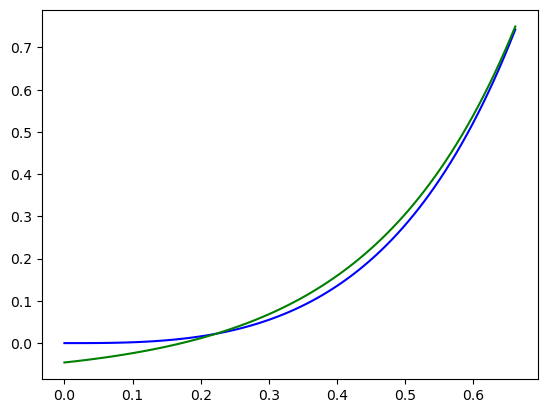

In [5]:
plt.plot(x[:85], y[:85], '-b', x[:85], fitted_curve[:85], '-g')
plt.show()

Yeesh! What if I fit this separately? With maybe a simpler polynomial curve?

poly1d([ 3.34894995e+00, -4.74160743e-01,  6.20997538e-01, -4.95570830e-02,
        3.16227768e-08])

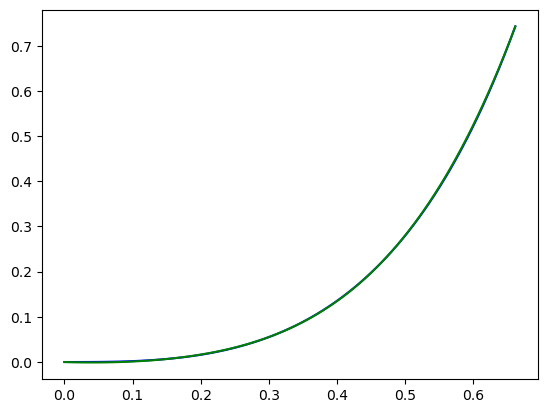

In [6]:
points_to_fit = np.array([ (x[i], y[i]) for i in [0, 20, 40, 60, 84]])
c = np.polyfit(points_to_fit[:,0], points_to_fit[:,1], 4)
g = np.poly1d(c)
ipd.display(g)
# plt.figure(figsize=(30,30))
plt.plot(x[:85], y[:85], '-b', x[:85], g(x[:85]), '-g')
plt.show()

Looking better, overlaying all of them, higher res:

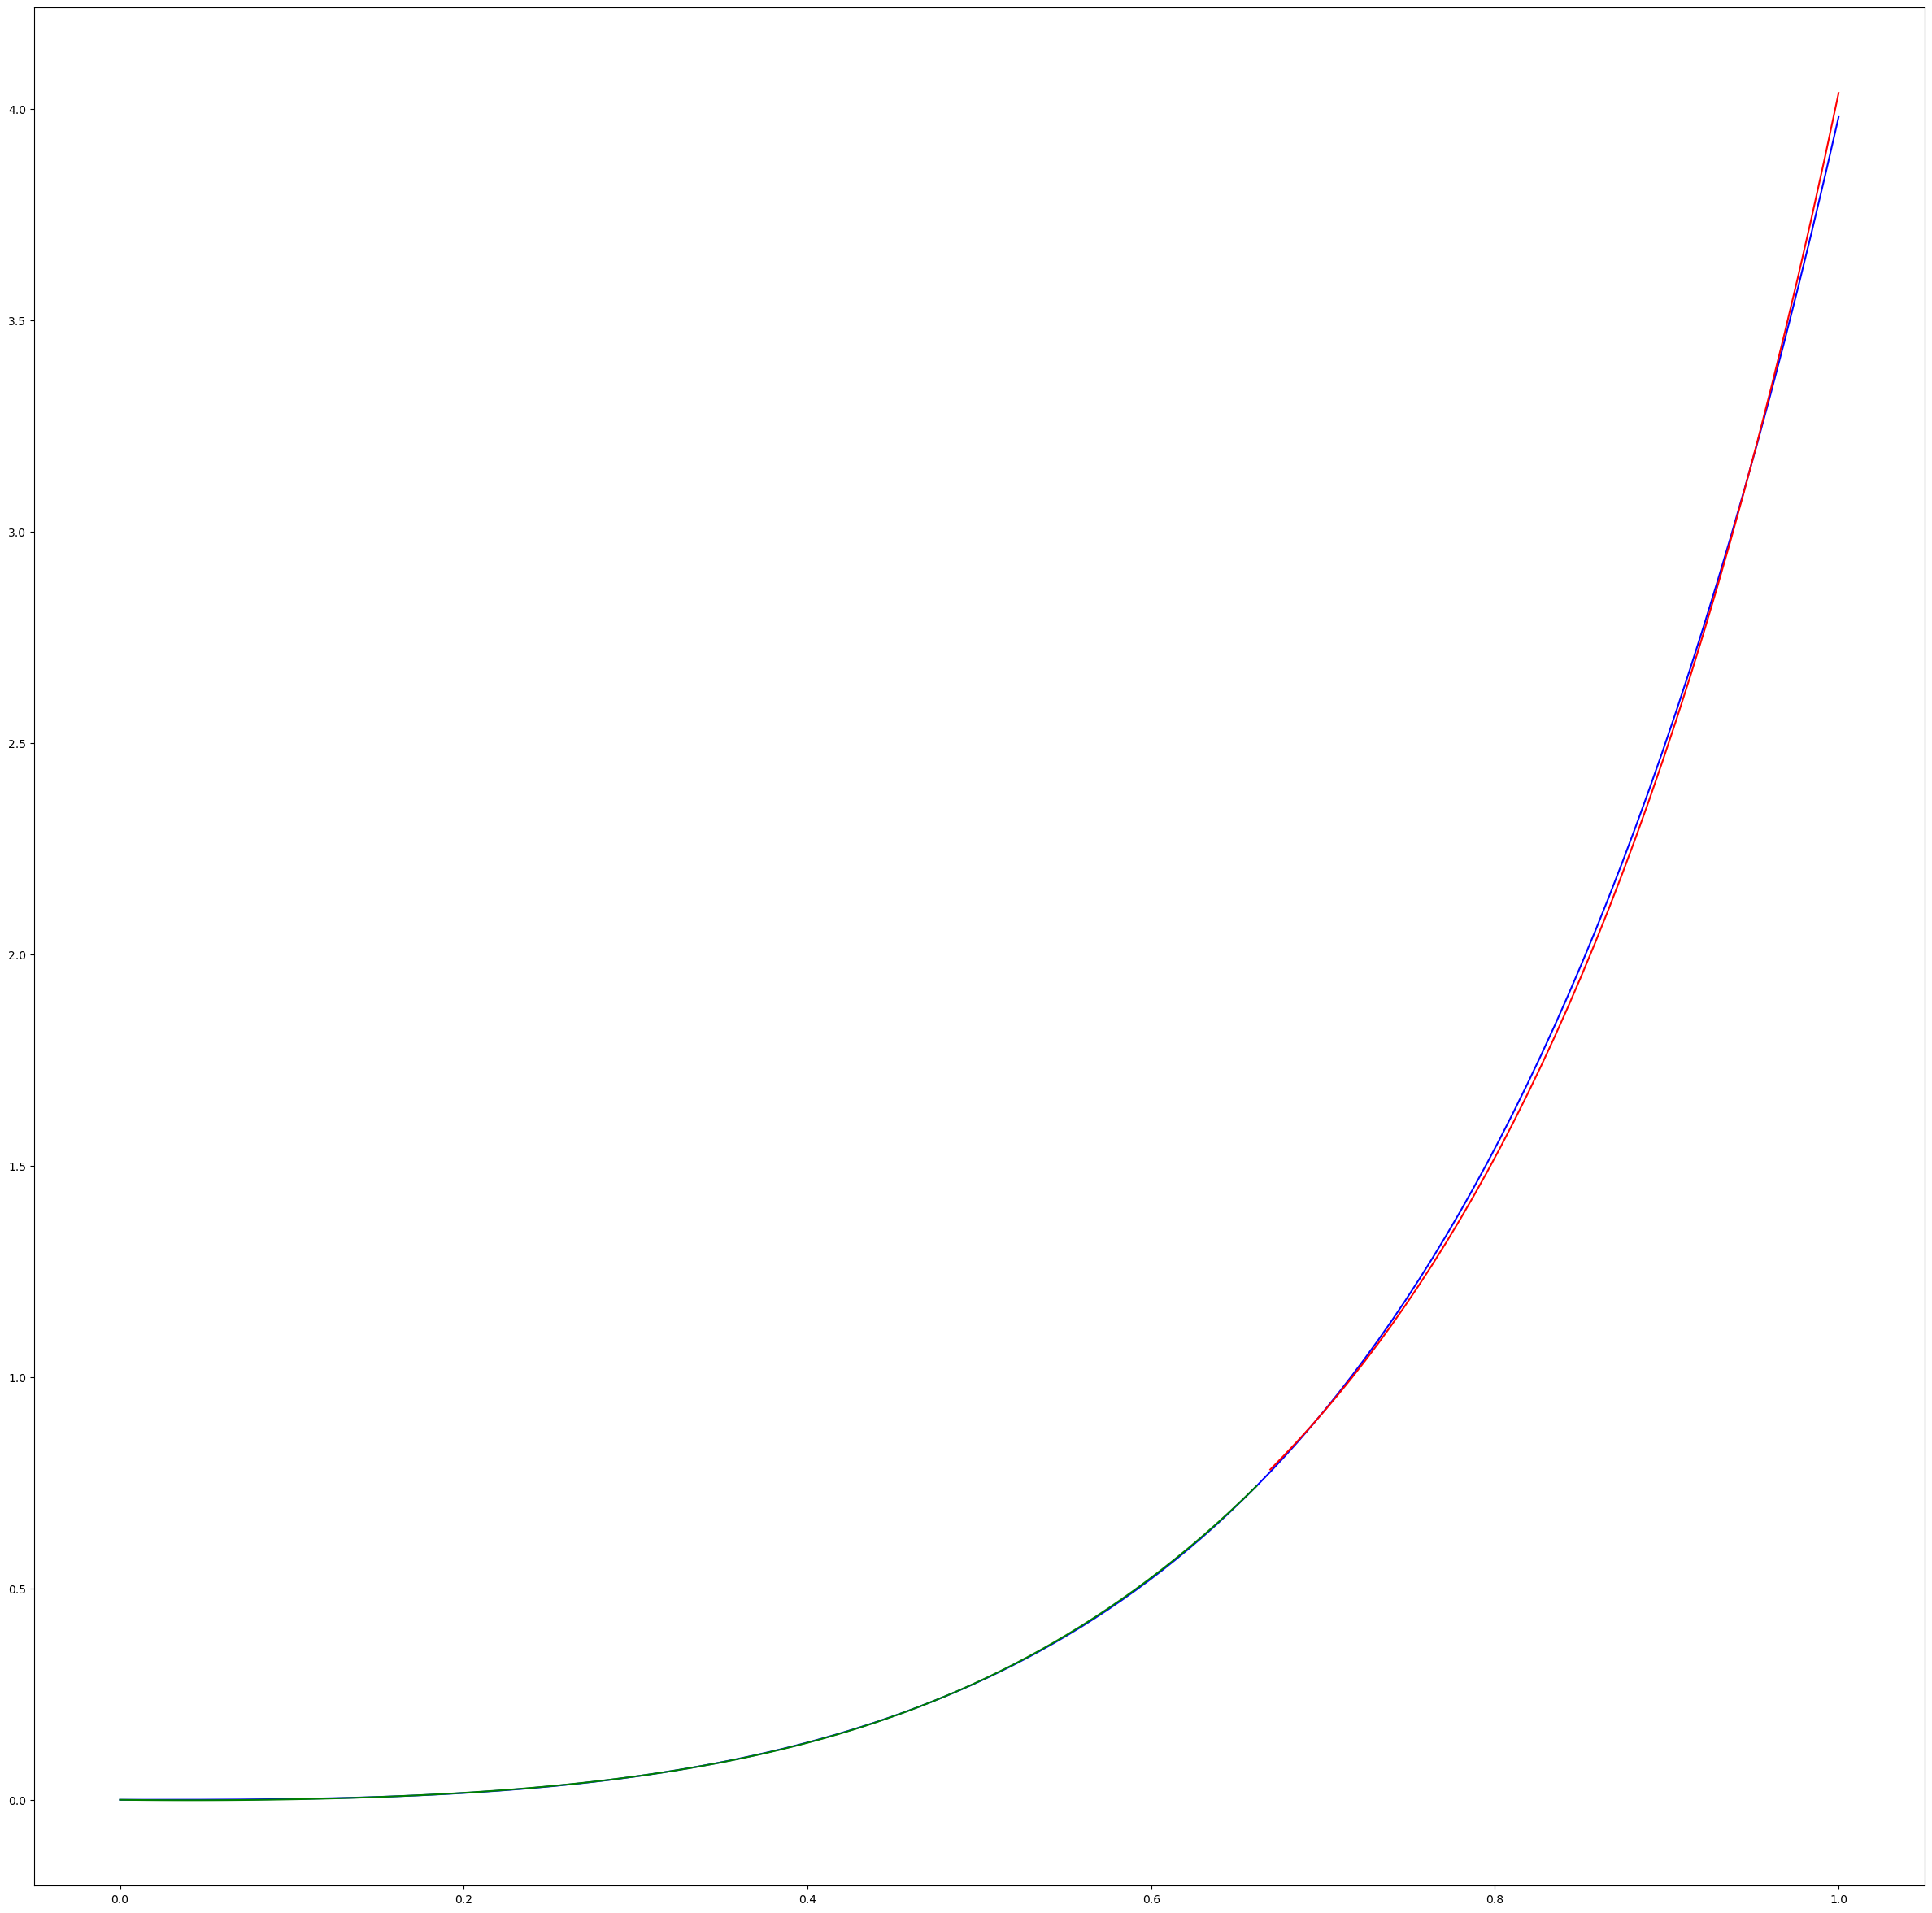

In [7]:
plt.figure(figsize=(30,30))
plt.plot(x, y, '-b', x[:85], g(x[:85]), '-g', x[85:], fitted_curve[85:], '-r')
plt.show()

This is looking pretty good, but, this is weird to use in code, I don't know the inverse (if it exists) of the poly, a reversed lookup table might be problematic / non-deterministic values from REAPER, when I tried to use it (splitting between the two), I have some kind of bug, fader jumped back down.

```js
let count = -1
const testSend = () => {
    count++
    const x = (count % 128) / 127.0
    const y = (x >= (85 / 127.0)) ?
        (0.03656071 * Math.exp(4.72474091 * x) - 0.08241487) :
        (3.34894995 * x -4.74160743e-01 * x**2 + 6.20997538e-01 * x**3 - 4.95570830e-02 * x**4 + 3.16227768e-08)

    // Send this gain to Reaper
    console.log(`Sending, midi val ${count % 128}, x: ${x}, gain val: ${y}`);
    client.write(`tval -1 D_VOL ${val}\n`);
};
setInterval(testSend, 20);
```